In [ ]:
import os
import copy
import random

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelBinarizer

import torch
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [ ]:
def read_csv_annotation(path, incorrect_labels_percent=0):
    if incorrect_labels_percent not in [0, 1, 5, 25, 50]:
        raise ValueError('incorrect_labels_percent should be in [0, 1, 5, 25, 50]')

    labels_column_name = f'noisy_labels_{incorrect_labels_percent}'
    annotation = pd.read_csv(path)

    annotation = annotation[['path', labels_column_name, 'is_valid']]
    annotation.rename(columns={labels_column_name: 'label'}, inplace=True)

    return annotation

In [ ]:
class ImageWoofDataset(Dataset):

    def __init__(self, annotation, root_dir, label_binarizer=None, transform=None):

        self.annotation = annotation
        self.root_dir = root_dir
        self.transform = transform
        self.label_binarizer = label_binarizer

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.annotation.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')

        label = self.annotation.iloc[index, 1]
        bin_label = self.label_binarizer.transform([label]).squeeze()

        if self.transform:
            image = self.transform(image)
        
        return {
            'X': torch.FloatTensor(np.array(image)),
            'y': torch.FloatTensor(bin_label)
        }

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, verbose=True):
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    metrics_history = {
        'train_accuracy': [],
        'val_accuracy': [],
        'train_loss': [],
        'val_loss': []
    }

    for epoch in tqdm(range(num_epochs), disable = not verbose):

        train_loss = 0.0
        train_corrects = 0.0
        model.train()
        for _, item in enumerate(train_loader):
            optimizer.zero_grad()

            X = item['X'].to(device)
            y = item['y'].to(device)
            
            predictions = model(X)

            loss = criterion(predictions, y)
            loss.backward()

            optimizer.step()

            train_loss += loss.item() * X.size(0)

            pred_labels = torch.argmax(predictions, dim=1)
            true_labels = torch.argmax(y, dim=1)
            train_corrects += torch.sum(pred_labels == true_labels).item()

        scheduler.step()

        val_loss = 0.0
        val_corrects = 0.0
        model.eval()
        for _, item in enumerate(val_loader):
            with torch.no_grad():
                X = item['X'].to(device)
                y = item['y'].to(device)

                predictions = model(X)
                
                loss = criterion(predictions, y)

                val_loss += loss.item() * X.size(0)

                pred_labels = torch.argmax(predictions, dim=1)
                true_labels = torch.argmax(y, dim=1)
                val_corrects += torch.sum(pred_labels == true_labels).item()

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)
        val_accuracy = val_corrects / len(val_loader.dataset)

        metrics_history['train_loss'].append(train_loss)
        metrics_history['val_loss'].append(val_loss)
        metrics_history['train_accuracy'].append(train_accuracy)
        metrics_history['val_accuracy'].append(val_accuracy)

        if verbose:
            print((f'Epoch {epoch + 1}  |  [train, val] loss: {round(train_loss, 5)}, {round(val_loss, 5)}'
                   f'  |  [train, val] acc: {round(train_accuracy, 3)}, {round(val_accuracy, 3)}'))
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, metrics_history

In [ ]:
def plot_metrics(metrics_history):
    nrows = (len(metrics_history) + 1) // 2
    fig, axes = plt.subplots(nrows, 2)

    for i, metric in enumerate(metrics_history):
        axes[i//2][i%2].plot(range(1, len(metrics_history[metric])+1),
                             metrics_history[metric],
                             color='green')
        axes[i//2][i%2].set_xlabel('epoch')
        axes[i//2][i%2].set_ylabel(metric)
    
    fig.set_figwidth(16)
    fig.set_figheight(5*nrows)
    fig.show()

In [ ]:
def predict(model, label_binarizer, image, transform=None):
    if transform:
        image = transform(image)
    
    with torch.no_grad():
        image_tensor = torch.FloatTensor(np.array(image)).unsqueeze(0).to(device)
        predictions = model(image_tensor).cpu().numpy()
        pred_classes = label_binarizer.inverse_transform(predictions, threshold=0)

    return pred_classes[0]

---

In [ ]:
! wget -q https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
! tar -zxf imagewoof2-320.tgz

In [ ]:
dataset_annotation = read_csv_annotation('imagewoof2-320/noisy_imagewoof.csv', incorrect_labels_percent=0)
train_annotation = dataset_annotation[dataset_annotation['is_valid'] == False].drop(columns=['is_valid'])
val_annotation = dataset_annotation[dataset_annotation['is_valid'] == True].drop(columns=['is_valid'])

In [ ]:
label_binarizer = LabelBinarizer().fit(dataset_annotation['label'])

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = ImageWoofDataset(train_annotation, 'imagewoof2-320', 
                                 label_binarizer=label_binarizer, 
                                 transform=train_transform)
val_dataset = ImageWoofDataset(val_annotation, 'imagewoof2-320', 
                               label_binarizer=label_binarizer, 
                               transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device.type)

cuda


In [ ]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
model, metrics_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, verbose=True)

Epoch 1  |  [train, val] loss: 0.30742, 0.30282  |  [train, val] acc: 0.249, 0.26
Epoch 2  |  [train, val] loss: 0.27062, 0.47128  |  [train, val] acc: 0.342, 0.179
Epoch 3  |  [train, val] loss: 0.25321, 0.29881  |  [train, val] acc: 0.397, 0.319
Epoch 4  |  [train, val] loss: 0.23485, 0.39909  |  [train, val] acc: 0.454, 0.222
Epoch 5  |  [train, val] loss: 0.2216, 0.31849  |  [train, val] acc: 0.498, 0.338
Epoch 6  |  [train, val] loss: 0.20964, 0.24957  |  [train, val] acc: 0.528, 0.459
Epoch 7  |  [train, val] loss: 0.1988, 0.23703  |  [train, val] acc: 0.557, 0.463
Epoch 8  |  [train, val] loss: 0.18491, 0.21328  |  [train, val] acc: 0.593, 0.536
Epoch 9  |  [train, val] loss: 0.17555, 0.23108  |  [train, val] acc: 0.623, 0.529
Epoch 10  |  [train, val] loss: 0.16615, 0.34533  |  [train, val] acc: 0.645, 0.414
Epoch 11  |  [train, val] loss: 0.15839, 0.20335  |  [train, val] acc: 0.662, 0.589
Epoch 12  |  [train, val] loss: 0.14888, 0.16565  |  [train, val] acc: 0.686, 0.641
Epoc

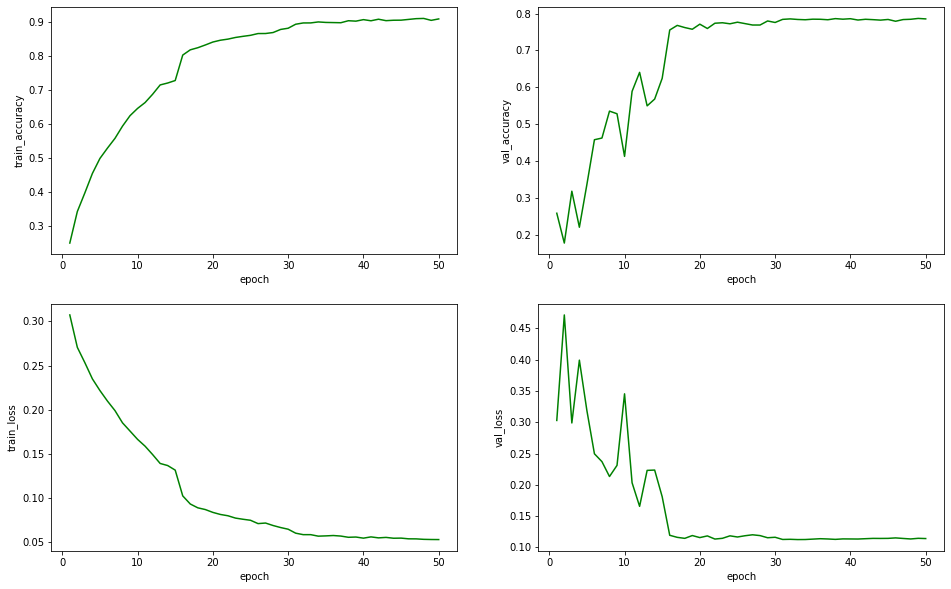

In [ ]:
plot_metrics(metrics_history)

In [ ]:
print('Best accuracy:', max(metrics_history['val_accuracy']))

Best accuracy: 0.7867141766352761


---

In [ ]:
dog_breed_name_from_codeword = {
  'n02086240': 'Shih-Tzu',
  'n02087394': 'Rhodesian ridgeback',
  'n02088364': 'Beagle',
  'n02089973': 'English foxhound',
  'n02093754': 'Australian terrier',
  'n02096294': 'Border terrier',
  'n02099601': 'Golden retriever',
  'n02105641': 'Old English sheepdog',
  'n02111889': 'Samoyed',
  'n02115641': 'Dingo'
}

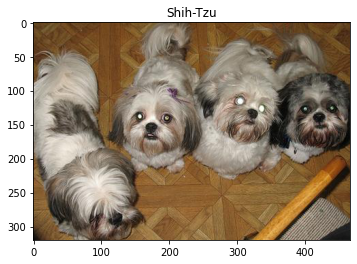

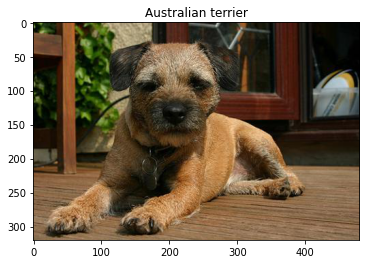

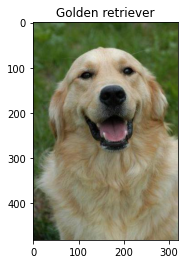

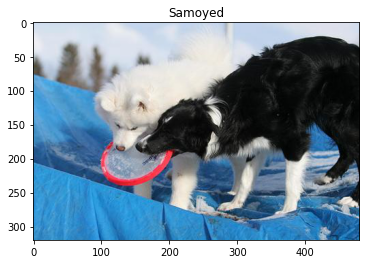

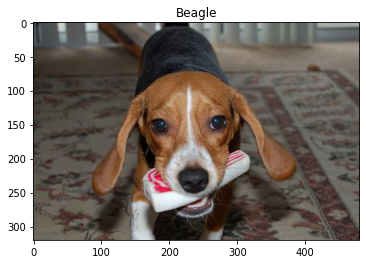

In [ ]:
n_examples = 5

for _ in range(n_examples):
    index = random.randint(0, len(val_annotation) - 1)
    img_path = os.path.join('imagewoof2-320', val_annotation.iloc[index, 0])
    img = Image.open(img_path).convert('RGB')

    pred_codeword = predict(model, label_binarizer, img, transform=val_transform)
    breed_name = dog_breed_name_from_codeword[pred_codeword]
     
    plt.imshow(img)
    plt.title(breed_name)
    plt.show()